In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# for neural net
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# for evaluation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# data plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv("data/combined_expression.csv")
data['cluster'].replace([1, 2],[0, 1],inplace=True)
data.head()

,CELL_LINE_NAME,cluster,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1,FKBPL
0,1240123,1,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022,6.447316
1,1240131,0,7.611268,2.704739,10.276079,3.650299,3.481567,3.145538,3.565127,7.861068,...,2.801456,2.985889,3.180068,5.415729,3.299858,3.028414,3.877889,3.911516,3.379405,4.729557
2,1240132,0,7.678658,2.845781,10.180954,3.573048,3.431235,3.090781,4.116643,8.121190,...,2.934962,2.952937,3.164655,5.707506,3.434295,2.961345,4.272194,3.085696,3.002557,5.653588
3,1240134,0,3.265063,3.063746,10.490285,3.340791,3.676912,3.512821,3.873922,8.790851,...,3.041839,3.398847,3.106710,5.773963,3.412641,3.136110,4.422262,3.522122,3.509437,5.953242
4,1240140,0,7.090138,2.988043,10.264692,4.119555,3.432585,3.308033,3.318371,6.927761,...,3.028787,3.225982,3.275820,5.334283,3.864678,3.259242,3.840581,5.809553,3.674587,5.577503


In [3]:
data.shape

(541, 16384)

In [4]:
selected_genes = pd.read_csv('cleaned/boruta.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))

In [5]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

# Confusion Matrix Plotting Function

In [33]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True, cbar=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names, rotation=90, verticalalignment='center')
#         plt.yticks([], ['', ''])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    if cbar:
        plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

# K-Folds Evaluation Function

In [7]:
def cv_eval(model, n_folds, X, y):
    """K-fold validation function for evaluation of a Keras model.
    Arguments:
        model: the model to evaluate.
        n_folds (int): the number of cross-folds.
        X: values of the feature variables.
        y: values of the classification.
    Returns:
        cms (list): confusion matrix for each cross-fold.
        histories (list): model metrics for each cross-fold.
        tprs (list): the True Positive Rate for each cross-fold.
        base_fpr (list): the cutoff points for the ROC curve.
    """
    kf = KFold(n_splits=n_folds)
    cms = []  # confusion matrix results
    histories = []  # for model analysis
    tprs = []  # for ROC analysis
    base_fpr = np.linspace(0, 1, 101)  # for ROC analysis
    
    for i_train, i_test in kf.split(X, y):
        X_train, X_test = X.iloc[i_train].values, X.iloc[i_test].values
        y_train, y_test = y[i_train], y[i_test]
        # recording model metrics and confusion matrix
        histories.append(model.fit(X_train, y_train, validation_data=(X_test, y_test)))
        cms.append(confusion_matrix(y_test, model.predict(X_test)))
        # recording for auc
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.
        tprs.append(tpr)
    
    return cms, histories, tprs, base_fpr

# 5-Fold Validation for 5 Hidden Layers

In [8]:
def hidden5(optimizer='adam', init='normal', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
model5 = KerasClassifier(build_fn=hidden5, epochs=50, batch_size=32, optimizer='adagrad',init='normal')
cm_results5, history5, tprs5, base_fpr5 = cv_eval(model5, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 4s 10ms/sample - loss: 0.6452 - accuracy: 0.7384 - val_loss: 0.7872 - val_accuracy: 0.6697
Epoch 2/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.4659 - accuracy: 0.8079 - val_loss: 0.5902 - val_accuracy: 0.6697
Epoch 3/50
432/432 [==============================] - 1s 3ms/sample - loss: 0.4254 - accuracy: 0.8287 - val_loss: 0.4888 - val_accuracy: 0.7339
Epoch 4/50
432/432 [==============================] - 1s 3ms/sample - loss: 0.4558 - accuracy: 0.8310 - val_loss: 0.3972 - val_accuracy: 0.8165
Epoch 5/50
432/432 [==============================] - 1s 3ms/sample - loss: 0.3984 - accuracy: 0.8333 - val_loss: 0.3148 - val_accuracy: 0.9083
Epoch 6/50
432/432 [==============================] - 1s 3ms/sample - loss: 0.3712 - accuracy: 0.8588 - val_loss: 0.3185 - val_accuracy: 0.9083
Epoch 7/50
432/432 [==============================] - 1s 3ms/sample - loss: 0.3741 - accu

Epoch 7/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.2947 - accuracy: 0.8961 - val_loss: 0.4489 - val_accuracy: 0.7963
Epoch 8/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.2826 - accuracy: 0.9053 - val_loss: 0.4510 - val_accuracy: 0.8056
Epoch 9/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2997 - accuracy: 0.8984 - val_loss: 0.4440 - val_accuracy: 0.8148
Epoch 10/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.3196 - accuracy: 0.8776 - val_loss: 0.4511 - val_accuracy: 0.8333
Epoch 11/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2805 - accuracy: 0.8845 - val_loss: 0.4607 - val_accuracy: 0.8056
Epoch 12/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2599 - accuracy: 0.9099 - val_loss: 0.4735 - val_accuracy: 0.8056
Epoch 13/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2222 - accuracy: 0.9307 - val_loss: 0.4632 - val_accur

433/433 [==============================] - 1s 2ms/sample - loss: 0.2436 - accuracy: 0.8961 - val_loss: 0.4673 - val_accuracy: 0.8056
Epoch 14/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2667 - accuracy: 0.8845 - val_loss: 0.4829 - val_accuracy: 0.7963
Epoch 15/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2136 - accuracy: 0.9145 - val_loss: 0.4799 - val_accuracy: 0.7963
Epoch 16/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2604 - accuracy: 0.9053 - val_loss: 0.4967 - val_accuracy: 0.8148
Epoch 17/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2337 - accuracy: 0.9076 - val_loss: 0.4888 - val_accuracy: 0.8333
Epoch 18/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2274 - accuracy: 0.9099 - val_loss: 0.4929 - val_accuracy: 0.8333
Epoch 19/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2071 - accuracy: 0.9192 - val_loss: 0.5034 - val_accuracy: 0.84

433/433 [==============================] - 1s 2ms/sample - loss: 0.2222 - accuracy: 0.9145 - val_loss: 0.5557 - val_accuracy: 0.8519
Epoch 20/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2440 - accuracy: 0.9145 - val_loss: 0.5939 - val_accuracy: 0.7778
Epoch 21/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2299 - accuracy: 0.9169 - val_loss: 0.5910 - val_accuracy: 0.7963
Epoch 22/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2570 - accuracy: 0.9122 - val_loss: 0.5803 - val_accuracy: 0.8056
Epoch 23/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2339 - accuracy: 0.9215 - val_loss: 0.5852 - val_accuracy: 0.8056
Epoch 24/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2393 - accuracy: 0.9145 - val_loss: 0.5998 - val_accuracy: 0.7963
Epoch 25/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2685 - accuracy: 0.9169 - val_loss: 0.6516 - val_accuracy: 0.76

433/433 [==============================] - 1s 2ms/sample - loss: 0.2009 - accuracy: 0.9238 - val_loss: 0.4518 - val_accuracy: 0.8519
Epoch 26/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2485 - accuracy: 0.9030 - val_loss: 0.4482 - val_accuracy: 0.8426
Epoch 27/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2039 - accuracy: 0.9076 - val_loss: 0.4307 - val_accuracy: 0.8611
Epoch 28/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1672 - accuracy: 0.9353 - val_loss: 0.4421 - val_accuracy: 0.8519
Epoch 29/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2606 - accuracy: 0.9099 - val_loss: 0.4734 - val_accuracy: 0.8148
Epoch 30/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.2013 - accuracy: 0.9330 - val_loss: 0.4717 - val_accuracy: 0.8333
Epoch 31/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1761 - accuracy: 0.9423 - val_loss: 0.4939 - val_accuracy: 0.76

In [14]:
cm5 = [[0, 0]]
k, l = 0, 0
for i in cm_results5:
    for j in cm_results5[0]:
        cm5[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm5 = np.array(cm5[0])

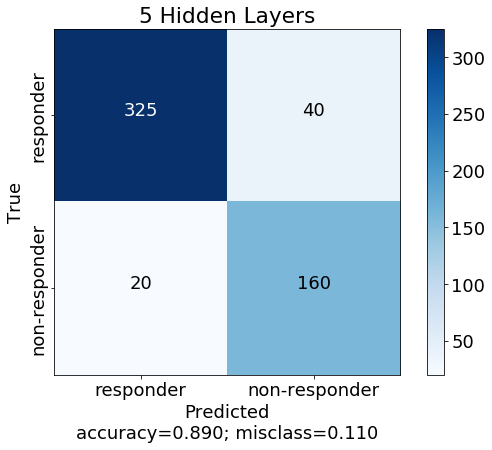

In [36]:
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm5, ['responder', 'non-responder'], title='5 Hidden Layers', normalize=False, cbar=True)

# 4 Hidden Layers

In [16]:
def hidden4(optimizer='adam', init='normal', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
model4 = KerasClassifier(build_fn=hidden4, epochs=50, batch_size=32, optimizer='adagrad',init='normal')
cm_results4, history4, tprs4, base_fpr4 = cv_eval(model4, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 3s 8ms/sample - loss: 0.7046 - accuracy: 0.7500 - val_loss: 0.3938 - val_accuracy: 0.9174
Epoch 2/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.4435 - accuracy: 0.8171 - val_loss: 0.4598 - val_accuracy: 0.8165
Epoch 3/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.4079 - accuracy: 0.8403 - val_loss: 0.3743 - val_accuracy: 0.9266
Epoch 4/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.3377 - accuracy: 0.8704 - val_loss: 0.3308 - val_accuracy: 0.9266
Epoch 5/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.3524 - accuracy: 0.8495 - val_loss: 0.3044 - val_accuracy: 0.9450
Epoch 6/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.3440 - accuracy: 0.8750 - val_loss: 0.3282 - val_accuracy: 0.8899
Epoch 7/50
432/432 [==============================] - 1s 1ms/sample - loss: 0.2896 - accur

Epoch 7/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.2779 - accuracy: 0.8868 - val_loss: 0.5694 - val_accuracy: 0.6852
Epoch 8/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.2361 - accuracy: 0.9076 - val_loss: 0.5103 - val_accuracy: 0.7593
Epoch 9/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.2034 - accuracy: 0.9353 - val_loss: 0.4941 - val_accuracy: 0.7870
Epoch 10/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.2279 - accuracy: 0.9192 - val_loss: 0.5365 - val_accuracy: 0.7685
Epoch 11/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1949 - accuracy: 0.9192 - val_loss: 0.5585 - val_accuracy: 0.7222
Epoch 12/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.2223 - accuracy: 0.9284 - val_loss: 0.6030 - val_accuracy: 0.7222
Epoch 13/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1853 - accuracy: 0.9076 - val_loss: 0.5231 - val_accur

433/433 [==============================] - 1s 1ms/sample - loss: 0.2073 - accuracy: 0.8915 - val_loss: 0.6303 - val_accuracy: 0.7500
Epoch 14/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1526 - accuracy: 0.9492 - val_loss: 0.5930 - val_accuracy: 0.7500
Epoch 15/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1790 - accuracy: 0.9330 - val_loss: 0.5981 - val_accuracy: 0.7870
Epoch 16/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1685 - accuracy: 0.9584 - val_loss: 0.5901 - val_accuracy: 0.7963
Epoch 17/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1057 - accuracy: 0.9654 - val_loss: 0.5999 - val_accuracy: 0.7963
Epoch 18/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1487 - accuracy: 0.9469 - val_loss: 0.6584 - val_accuracy: 0.7500
Epoch 19/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1602 - accuracy: 0.9353 - val_loss: 0.6741 - val_accuracy: 0.75

433/433 [==============================] - 1s 2ms/sample - loss: 0.1645 - accuracy: 0.9446 - val_loss: 0.6034 - val_accuracy: 0.8426
Epoch 20/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1468 - accuracy: 0.9446 - val_loss: 0.6625 - val_accuracy: 0.8333
Epoch 21/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1601 - accuracy: 0.9538 - val_loss: 0.6411 - val_accuracy: 0.8426
Epoch 22/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1385 - accuracy: 0.9400 - val_loss: 0.6386 - val_accuracy: 0.8426
Epoch 23/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1836 - accuracy: 0.9330 - val_loss: 0.7035 - val_accuracy: 0.8241
Epoch 24/50
433/433 [==============================] - 1s 2ms/sample - loss: 0.1394 - accuracy: 0.9584 - val_loss: 0.7256 - val_accuracy: 0.8148
Epoch 25/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1194 - accuracy: 0.9584 - val_loss: 0.6949 - val_accuracy: 0.83

433/433 [==============================] - 1s 1ms/sample - loss: 0.1406 - accuracy: 0.9584 - val_loss: 0.6101 - val_accuracy: 0.7593
Epoch 26/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1455 - accuracy: 0.9469 - val_loss: 0.5512 - val_accuracy: 0.8056
Epoch 27/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1424 - accuracy: 0.9492 - val_loss: 0.5053 - val_accuracy: 0.7870
Epoch 28/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1103 - accuracy: 0.9654 - val_loss: 0.4777 - val_accuracy: 0.7870
Epoch 29/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1610 - accuracy: 0.9238 - val_loss: 0.4482 - val_accuracy: 0.7963
Epoch 30/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1229 - accuracy: 0.9584 - val_loss: 0.4936 - val_accuracy: 0.7593
Epoch 31/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1213 - accuracy: 0.9515 - val_loss: 0.4917 - val_accuracy: 0.78

In [18]:
cm4 = [[0, 0]]
k, l = 0, 0
for i in cm_results4:
    for j in cm_results4[0]:
        cm4[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm4 = np.array(cm4[0])

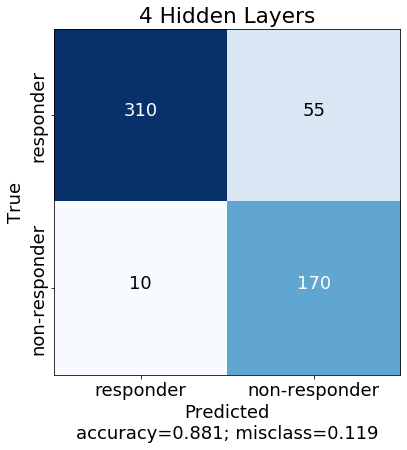

In [35]:
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm4, ['responder', 'non-responder'], title='4 Hidden Layers', normalize=False, cbar=False)

# 3 Hidden Layers

In [20]:
def hidden3(optimizer='rmsprop',init='glorot_uniform', dropout=0.3):
    model = Sequential()
    # adding layers and adding droplayers to avoid overfitting
    hidden_layers = len(selected_genes)
    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(hidden_layers*2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
model3 = KerasClassifier(build_fn=hidden3, epochs=50, batch_size=32, optimizer='adagrad',init='normal')
cm_results3, history3, tprs3, base_fpr3 = cv_eval(model3, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/50
432/432 [==============================] - 3s 6ms/sample - loss: 0.7198 - accuracy: 0.7662 - val_loss: 0.2253 - val_accuracy: 0.9174
Epoch 2/50
432/432 [==============================] - 0s 926us/sample - loss: 0.4552 - accuracy: 0.8171 - val_loss: 0.3209 - val_accuracy: 0.8716
Epoch 3/50
432/432 [==============================] - 0s 920us/sample - loss: 0.3820 - accuracy: 0.8472 - val_loss: 0.6084 - val_accuracy: 0.6330
Epoch 4/50
432/432 [==============================] - 0s 936us/sample - loss: 0.3181 - accuracy: 0.8634 - val_loss: 0.5762 - val_accuracy: 0.6881
Epoch 5/50
432/432 [==============================] - 0s 950us/sample - loss: 0.3259 - accuracy: 0.8634 - val_loss: 0.3999 - val_accuracy: 0.8257
Epoch 6/50
432/432 [==============================] - 0s 959us/sample - loss: 0.2940 - accuracy: 0.8750 - val_loss: 0.3112 - val_accuracy: 0.8807
Epoch 7/50
432/432 [==============================] - 0s 986us/sample - loss: 0.

Epoch 7/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.2282 - accuracy: 0.9076 - val_loss: 0.4258 - val_accuracy: 0.8148
Epoch 8/50
433/433 [==============================] - 0s 974us/sample - loss: 0.1742 - accuracy: 0.9284 - val_loss: 0.4311 - val_accuracy: 0.8241
Epoch 9/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1929 - accuracy: 0.9307 - val_loss: 0.4337 - val_accuracy: 0.8426
Epoch 10/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1768 - accuracy: 0.9307 - val_loss: 0.5026 - val_accuracy: 0.8148
Epoch 11/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1897 - accuracy: 0.9307 - val_loss: 0.5188 - val_accuracy: 0.8241
Epoch 12/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.2109 - accuracy: 0.9307 - val_loss: 0.5588 - val_accuracy: 0.7315
Epoch 13/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1433 - accuracy: 0.9400 - val_loss: 0.6163 - val_acc

433/433 [==============================] - 0s 1ms/sample - loss: 0.1678 - accuracy: 0.9353 - val_loss: 1.0900 - val_accuracy: 0.5463
Epoch 14/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1616 - accuracy: 0.9400 - val_loss: 0.6075 - val_accuracy: 0.7222
Epoch 15/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1756 - accuracy: 0.9330 - val_loss: 0.6812 - val_accuracy: 0.6759
Epoch 16/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1076 - accuracy: 0.9700 - val_loss: 0.6520 - val_accuracy: 0.7315
Epoch 17/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1319 - accuracy: 0.9469 - val_loss: 0.7637 - val_accuracy: 0.6759
Epoch 18/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1348 - accuracy: 0.9376 - val_loss: 0.6349 - val_accuracy: 0.7315
Epoch 19/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.0988 - accuracy: 0.9723 - val_loss: 0.6270 - val_accuracy: 0.74

433/433 [==============================] - 0s 1ms/sample - loss: 0.1889 - accuracy: 0.9353 - val_loss: 0.5204 - val_accuracy: 0.8426
Epoch 20/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1200 - accuracy: 0.9607 - val_loss: 0.5454 - val_accuracy: 0.8148
Epoch 21/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1503 - accuracy: 0.9400 - val_loss: 0.5035 - val_accuracy: 0.8519
Epoch 22/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1092 - accuracy: 0.9700 - val_loss: 0.5172 - val_accuracy: 0.8611
Epoch 23/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1651 - accuracy: 0.9446 - val_loss: 0.5622 - val_accuracy: 0.8148
Epoch 24/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1103 - accuracy: 0.9607 - val_loss: 0.6215 - val_accuracy: 0.7870
Epoch 25/50
433/433 [==============================] - 1s 1ms/sample - loss: 0.1204 - accuracy: 0.9515 - val_loss: 0.5822 - val_accuracy: 0.83

433/433 [==============================] - 0s 1ms/sample - loss: 0.1421 - accuracy: 0.9423 - val_loss: 0.5242 - val_accuracy: 0.7870
Epoch 26/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1145 - accuracy: 0.9538 - val_loss: 0.5778 - val_accuracy: 0.7778
Epoch 27/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1112 - accuracy: 0.9561 - val_loss: 0.5884 - val_accuracy: 0.7407
Epoch 28/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1113 - accuracy: 0.9654 - val_loss: 0.5172 - val_accuracy: 0.7870
Epoch 29/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1134 - accuracy: 0.9584 - val_loss: 0.5705 - val_accuracy: 0.7778
Epoch 30/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.1146 - accuracy: 0.9584 - val_loss: 0.5039 - val_accuracy: 0.8148
Epoch 31/50
433/433 [==============================] - 0s 1ms/sample - loss: 0.0852 - accuracy: 0.9654 - val_loss: 0.4941 - val_accuracy: 0.81

In [22]:
cm3 = [[0, 0]]
k, l = 0, 0
for i in cm_results3:
    for j in cm_results3[0]:
        cm3[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm3 = np.array(cm3[0])
cm3

array([[330,  35],
       [ 25, 155]])

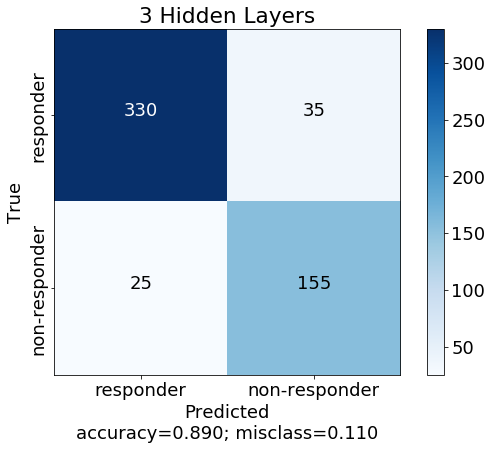

In [34]:
plt.rcParams.update({'font.size': 18})
plot_confusion_matrix(cm3, ['responder', 'non-responder'], title='3 Hidden Layers', normalize=False)

# Comparison Plots

In [24]:
# for 5 hidden layers
tprs5 = np.array(tprs5)
mean_tprs5 = tprs5.mean(axis=0)
std5 = tprs5.std(axis=0)
tprs_upper5 = np.minimum(mean_tprs5 + std5, 1)
tprs_lower5 = mean_tprs5 - std5
auc5 = auc(base_fpr5, mean_tprs5)

In [25]:
# for 4 hidden layers
tprs4 = np.array(tprs4)
mean_tprs4 = tprs4.mean(axis=0)
std4 = tprs4.std(axis=0)
tprs_upper4 = np.minimum(mean_tprs4 + std4, 1)
tprs_lower4 = mean_tprs4 - std4
auc4 = auc(base_fpr4, mean_tprs4)

In [26]:
# for 3 hidden layers
tprs3 = np.array(tprs3)
mean_tprs3 = tprs3.mean(axis=0)
std3 = tprs3.std(axis=0)
tprs_upper3 = np.minimum(mean_tprs3 + std3, 1)
tprs_lower3 = mean_tprs3 - std3
auc3 = auc(base_fpr3, mean_tprs3)

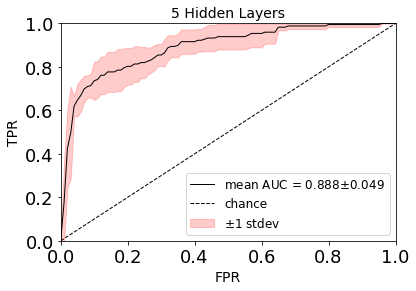

In [27]:
# 5 hidden layers
plt.plot(base_fpr5, mean_tprs5, color='k', linewidth=1)
plt.fill_between(base_fpr5, tprs_lower5, tprs_upper5, alpha=0.2, color='r')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('5 Hidden Layers', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.legend(['mean AUC = ' + str(round(auc5, 3)) + '$\pm$' + str(round(np.mean(std5), 3)), 'chance', '$\pm1$ stdev'],
           fontsize=12)

plt.show()

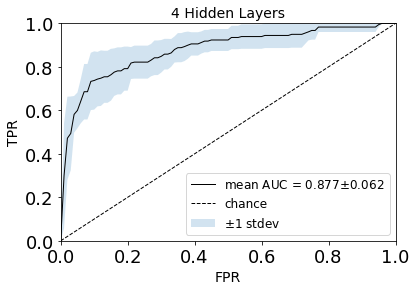

In [28]:
# 4 hidden layers
plt.plot(base_fpr4, mean_tprs4, 'k', linewidth=1)
plt.fill_between(base_fpr4, tprs_lower4, tprs_upper4, alpha=0.2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('4 Hidden Layers', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.legend(['mean AUC = ' + str(round(auc4, 3)) + '$\pm$' + str(round(np.mean(std4), 3)), 'chance', '$\pm1$ stdev'],
           fontsize=12)
plt.show()

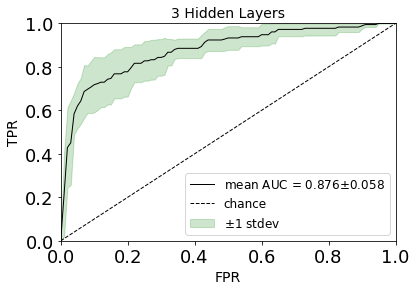

In [29]:
# 3 hidden layers
plt.plot(base_fpr3, mean_tprs3, 'k', linewidth=1)
plt.fill_between(base_fpr3, tprs_lower3, tprs_upper3, alpha=0.2, color='g')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('3 Hidden Layers', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.legend(['mean AUC = ' + str(round(auc3, 3)) + '$\pm$' + str(round(np.mean(std3), 3)),
            'chance',
            '$\pm1$ stdev'],
           fontsize=12)
plt.show()

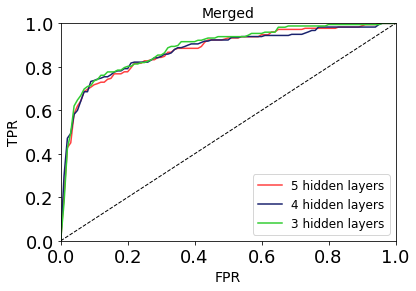

In [30]:
# merged
# 5 hidden layers
plt.plot(base_fpr3, mean_tprs3, '#ff0000', linewidth=1.5, alpha=0.75)
# 4 hidden layers
plt.plot(base_fpr4, mean_tprs4, '#1a236e', linewidth=1.5, alpha=1)
# 3 hidden layers
plt.plot(base_fpr5, mean_tprs5, '#32CD32', linewidth=1.5, alpha=1)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Merged', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.legend(['5 hidden layers',
            '4 hidden layers',
            '3 hidden layers'],
           fontsize=12)

plt.show()